#Prepare environment

In [38]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graph

In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statistics as stats
import math

# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, asc, desc, col, size, array_contains,\
isnan, udf, hour, array_min, array_max, countDistinct, regexp_extract, count, when
from pyspark.sql.functions import avg, struct, sum, explode, collect_list, array_repeat,\
size, collect_set, array
from pyspark.sql.types import *

In [41]:
#Support function
def show_head(df):
  display(df.limit(5).toPandas())

def count_missings(spark_df,sort=False):
    """
    Counts number of nulls and nans in each column
    """
    df = spark_df.select([functions.count(functions.when(functions.isnan(c) | functions.isnull(c), c)).alias(c) for (c,c_type) in spark_df.dtypes if c_type not in ('timestamp',  'date')]).toPandas()

    if len(df) == 0:
        print("There are no any missing values!")
        return None

    if sort:
        return df.rename(index={0: 'count'}).T.sort_values("count",ascending=False)

    return df

In [42]:
MAX_MEMORY = '10G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10005) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark(appName):
    spark = SparkSession \
        .builder \
        .appName(appName) \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark("Preprocessing Online Retail Dataset For RFM")
spark

# Starting to preprocess data

In [67]:
#Load data
filePath = '/content/gdrive/MyDrive/LDS02_k271_NguyenMinhQuan/Problem_2_RFM_SegmetationAnalysys/OnlineRetail.csv'
df = spark.read.csv(filePath, header = True, inferSchema=True).cache()
df.show(10)

+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+----------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01-12-2010 08:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01-12-2010 08:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01-12-2010 08:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01-12-2010 08:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01-12-2010 08:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|01-12-2010 08:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|01-1

In [44]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [45]:
#overview data
df.describe().show()

+-------+------------------+------------------+--------------------+-----------------+----------------+-----------------+------------------+-----------+
|summary|         InvoiceNo|         StockCode|         Description|         Quantity|     InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+------------------+------------------+--------------------+-----------------+----------------+-----------------+------------------+-----------+
|  count|            541909|            541909|              540455|           541909|          541909|           541909|            406829|     541909|
|   mean|  559965.752026781|27623.240210938104|             20713.0| 9.55224954743324|            null|4.611113626082965|15287.690570239585|       null|
| stddev|13428.417280799484| 16799.73762842768|                null|218.0811578502348|            null|96.75985306117944|1713.6003033215932|       null|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|           -80

In [46]:
#Check missing values
count_missings(df)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,0,1454,0,0,0,135080,0


In [68]:
df = df.drop_duplicates()

# Preprocessing steps

1. Cast InvoiceDate to datetime object 
2. InvoiceNo is String => if within it contains 'C', then it was cancelled, drop their rows and cast to integer
3. UnitPrice, Quantity is negative? (Drop them)
4. Drop missing records 
5. Drop non useful features (StockCode, Description)
6. Create new feature TotalPrice = Quantity*UnitPrice
7. Group records by customer id, caculate R F M for each customer
8. Save clean data to a csv file

In [69]:
#Correct data type
df = df.withColumn('InvoiceDate', functions.to_timestamp(df.InvoiceDate, 'dd-MM-yyyy HH:ss'))
df.show(20)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:00:26|     2.75|     17850|United Kingdom|
|   536406|   85123A|WHITE HANGING HEA...|       8|2010-12-01 11:00:33|     2.55|     17850|United Kingdom|
|   536423|    22619|SET OF 6 SOLDIER ...|       4|2010-12-01 12:00:08|     3.75|     18085|United Kingdom|
|   536446|    22294|HEART FILIGREE DO...|      48|2010-12-01 12:00:15|     1.25|     15983|United Kingdom|
|   536520|    22241|GARLAND WOODEN HA...|       2|2010-12-01 12:00:43|     1.25|     14729|United Kingdom|
|   536522|    22865|HAND WARMER OWL D...|       2|2010-12-01 12:00:49|      2.1|     15012|United Kingdom|
|   536532|    22567|20 DOLL

In [70]:
#Clean InvoiceNo
df = df.filter(df['InvoiceNo'].rlike('^[0-9\/]+$'))
df = df.withColumn(
    'InvoiceNo',
    df['InvoiceNo'].cast(IntegerType())
)

df.printSchema()

root
 |-- InvoiceNo: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [71]:
#Drop missing records and unused columns
df = df.drop('Description')
df = df.drop('StockCode')
df = df.dropna()

In [72]:
count_missings(df)

,InvoiceNo,Quantity,UnitPrice,CustomerID,Country
0,0,0,0,0,0


In [53]:
#Clean Quantity and UnitPrice for getting negative number
t = df.filter('Quantity <= 0 OR UnitPrice <= 0')
print(f"There are total {t.count()} invalid rows")
t.show()

There are total 40 invalid rows
+---------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+--------+-------------------+---------+----------+--------------+
|   577696|       1|2011-11-21 11:00:57|      0.0|     16406|United Kingdom|
|   575579|      24|2011-11-10 11:00:49|      0.0|     13081|United Kingdom|
|   561669|      11|2011-07-28 17:00:09|      0.0|     12507|         Spain|
|   539722|      10|2010-12-21 13:00:45|      0.0|     14911|          EIRE|
|   571035|       1|2011-10-13 12:00:50|      0.0|     12446|           RSA|
|   561284|       1|2011-07-26 12:00:24|      0.0|     16818|United Kingdom|
|   572893|       5|2011-10-26 14:00:36|      0.0|     18059|United Kingdom|
|   541109|       1|2011-01-13 15:00:10|      0.0|     15107|United Kingdom|
|   548318|       5|2011-03-30 12:00:45|      0.0|     13113|United Kingdom|
|   561916|       1|2011-08-01 11:00:44|    

In [73]:
df = df.filter('Quantity > 0 AND UnitPrice > 0')

In [74]:
#Create new feature TotalPrice
df = df.withColumn('TotalPrice', df['Quantity'] * df['UnitPrice'])
# Drop unneeed colums
df = df.drop('Quantity')
df = df.drop('UnitPrice')
show_head(df)

,InvoiceNo,InvoiceDate,CustomerID,Country,TotalPrice
0,536365,2010-12-01 08:00:26,17850,United Kingdom,22.0
1,536406,2010-12-01 11:00:33,17850,United Kingdom,20.4
2,536423,2010-12-01 12:00:08,18085,United Kingdom,15.0
3,536446,2010-12-01 12:00:15,15983,United Kingdom,60.0
4,536520,2010-12-01 12:00:43,14729,United Kingdom,2.5


In [56]:
df.describe().show()

+-------+-----------------+------------------+-----------+------------------+
|summary|        InvoiceNo|        CustomerID|    Country|        TotalPrice|
+-------+-----------------+------------------+-----------+------------------+
|  count|           392692|            392692|     392692|            392692|
|   mean|560590.8750471107|15287.843864911942|       null|22.631499735161402|
| stddev|13087.06375899506| 1713.539548924817|       null| 311.0992243348035|
|    min|           536365|             12346|  Australia|             0.001|
|    max|           581587|             18287|Unspecified|          168469.6|
+-------+-----------------+------------------+-----------+------------------+



In [57]:
df.filter('TotalPrice <= 0').show()

+---------+-----------+----------+-------+----------+
|InvoiceNo|InvoiceDate|CustomerID|Country|TotalPrice|
+---------+-----------+----------+-------+----------+
+---------+-----------+----------+-------+----------+



In [58]:
hour = udf(lambda x: x.hour, IntegerType())
month = udf(lambda x: x.month, IntegerType())

In [59]:
#Get time attribute
df = df.withColumn('month', month(df['InvoiceDate']))
df = df.withColumn('dayofweek', functions.dayofweek(df['InvoiceDate']))
df = df.withColumn('hour', hour(df['InvoiceDate']))

## Time analysis

In [60]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType

@pandas_udf(IntegerType(), functionType=PandasUDFType.GROUPED_AGG)
def countCustomer(customers):
    return len(customers.unique())

@pandas_udf(IntegerType(), functionType=PandasUDFType.GROUPED_AGG)                                        
def numberOfOrder(ino):                                        
    return len(ino.unique())

@pandas_udf(FloatType(), functionType=PandasUDFType.GROUPED_AGG)                                        
def totalPrice(total):                                        
    return round(np.sum(total)/1000,2)



/content/spark-3.1.2-bin-hadoop2.7/python/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [61]:
def get_report(groupColumn): 
    return df.groupby(groupColumn).agg(
          countCustomer('CustomerID').alias('TotalCustomer'),
          totalPrice('TotalPrice').alias('TotalSale'),
          numberOfOrder('InvoiceNo').alias('NumberOfOrders')
        ).toPandas().sort_values(by=groupColumn)


In [62]:
month_report = get_report('month')
month_report

,month,TotalCustomer,TotalSale,NumberOfOrders
1,1,741,568.099976,987
11,2,758,446.079987,997
3,3,974,594.080017,1321
6,4,856,468.369995,1149
4,5,1056,677.359985,1555
2,6,991,660.049988,1393
8,7,949,598.960022,1331
7,8,935,644.049988,1280
5,9,1266,950.690002,1755
9,10,1364,1035.640015,1929


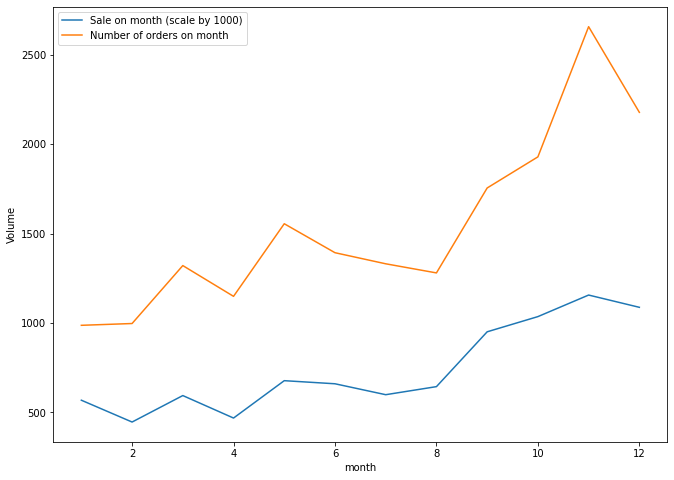

In [63]:
f, ax = plt.subplots(figsize=(11,8))
sns.lineplot(data = month_report, x = 'month', y = 'TotalSale', label = 'Sale on month (scale by 1000)', ax = ax)
sns.lineplot(data = month_report, x = 'month', y = 'NumberOfOrders', label='Number of orders on month', ax = ax)
ax.set_ylabel('Volume')
plt.legend()
plt.show()


The customer spending up trend over month, and go down when come to December. The top is at November, some event is happening in this time.

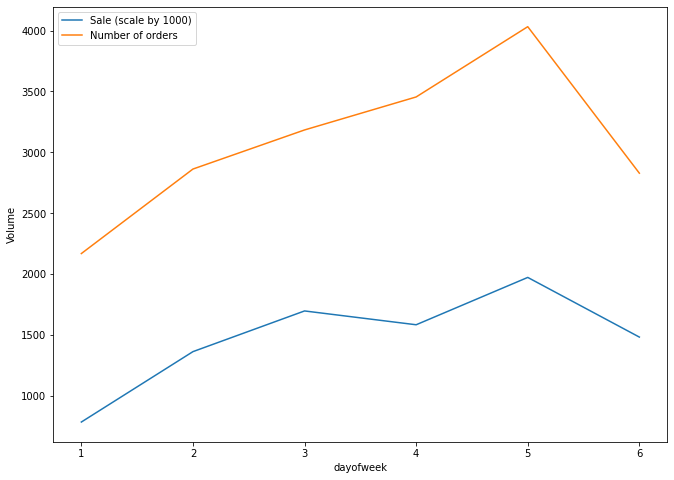

In [64]:
day_report = get_report('dayofweek')
f, ax = plt.subplots(figsize=(11,8))
sns.lineplot(data = day_report, x = 'dayofweek', y = 'TotalSale', label = 'Sale (scale by 1000)')
sns.lineplot(data = day_report, x = 'dayofweek', y = 'NumberOfOrders', label='Number of orders')
ax.set_ylabel('Volume')
plt.legend()
plt.show()



Customer spending mostly in Friday

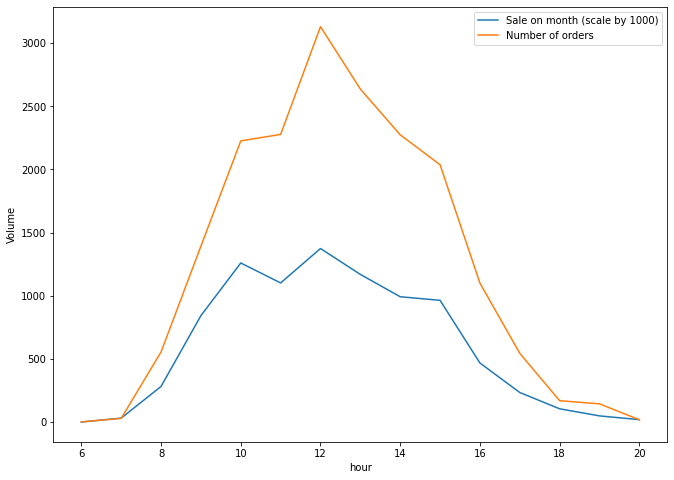

In [65]:
day_report = get_report('hour')
f, ax = plt.subplots(figsize=(11,8))
sns.lineplot(data = day_report, x = 'hour', y = 'TotalSale', label = 'Sale on month (scale by 1000)')
sns.lineplot(data = day_report, x = 'hour', y = 'NumberOfOrders', label='Number of orders')
ax.set_ylabel('Volume')
plt.legend()
plt.show()



Customer also spending mostly on 12:00 PM, in their lunch times, while in early or late of the day, it goes down. What did happens here? Why was that?

#### Group customer and caculate R F M


In [88]:
#Get max_date
max_date = df.select(functions.max('InvoiceDate')).first()[0]


In [89]:
max_date

datetime.datetime(2011, 12, 9, 12, 0, 50)

In [90]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType

@pandas_udf(IntegerType(), functionType=PandasUDFType.GROUPED_AGG)
def recency(date_):
    diff = (max_date - date_.max()).days
    return diff if diff >= 0 else 0

@pandas_udf(IntegerType(), functionType=PandasUDFType.GROUPED_AGG)                                        
def frequency(ino):                                        
    return len(ino.unique())

@pandas_udf(FloatType(), functionType=PandasUDFType.GROUPED_AGG)                                        
def monetary(total):                                        
    return round(np.sum(total),2)


@pandas_udf(StringType(), functionType=PandasUDFType.GROUPED_AGG)                                        
def get_country(country):                                        
    return country.iloc[0]

/content/spark-3.1.2-bin-hadoop2.7/python/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [91]:
#Group by each customer and apply R F M udf

rfm = df.groupby('CustomerID').agg(
 recency('InvoiceDate'),
 frequency('InvoiceNo'),
 monetary('TotalPrice'),
 get_country('Country')
)

show_head(rfm)

,CustomerID,recency(InvoiceDate),frequency(InvoiceNo),monetary(TotalPrice),get_country(Country)
0,12940,54,2,899.690002,United Kingdom
1,13285,22,4,2709.120117,United Kingdom
2,13623,30,5,727.739990,United Kingdom
3,13832,18,1,52.200001,United Kingdom
4,14450,180,3,483.250000,United Kingdom


In [92]:
df.where(df['CustomerID'] == 13832).show()

+---------+-------------------+----------+--------------+------------------+
|InvoiceNo|        InvoiceDate|CustomerID|       Country|        TotalPrice|
+---------+-------------------+----------+--------------+------------------+
|   577556|2011-11-20 15:00:36|     13832|United Kingdom|              17.4|
|   577556|2011-11-20 15:00:36|     13832|United Kingdom|19.799999999999997|
|   577556|2011-11-20 15:00:36|     13832|United Kingdom|              15.0|
+---------+-------------------+----------+--------------+------------------+



In [93]:
rfm.describe().show()

+-------+------------------+--------------------+--------------------+--------------------+--------------------+
|summary|        CustomerID|recency(InvoiceDate)|frequency(InvoiceNo)|monetary(TotalPrice)|get_country(Country)|
+-------+------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              4338|                4338|                4338|                4338|                4338|
|   mean|15300.408022130014|   91.53642231443061|   4.272014753342554|  2048.6880853099174|                null|
| stddev|1721.8084917653177|  100.01416863571653|   7.697997826095036|   8985.230337669407|                null|
|    min|             12346|                   0|                   1|                3.75|           Australia|
|    max|             18287|                 373|                 209|           280206.03|         Unspecified|
+-------+------------------+--------------------+--------------------+--------------------+-----

In [94]:
rfm.count()

4338

In [95]:
#Save data
rootPath = '/content/gdrive/MyDrive/LDS02_k271_NguyenMinhQuan/Problem_2_RFM_SegmetationAnalysys'
data = rfm.toPandas()
data.columns = ['customer', 'recency', 'frequency', 'monetary', 'country']

data.head()

,customer,recency,frequency,monetary,country
0,12940,54,2,899.690002,United Kingdom
1,13285,22,4,2709.120117,United Kingdom
2,13623,30,5,727.739990,United Kingdom
3,13832,18,1,52.200001,United Kingdom
4,14450,180,3,483.250000,United Kingdom


In [96]:
data.to_csv(rootPath + '/RFM_OnlineRetail.csv')

In [97]:
#Done the job close the session
spark.stop()